In [2]:
pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.3 MB/s eta 0:00:00


Total patients: 6823
Patient IDs: [3000003, 3000031, 3000051, 3000060, 3000063, 3000065, 3000086, 3000100, 3000103, 3000105]
['30/3000003/3000003', '30/3000003/3000003n', '30/3000003/3000003_0001', '30/3000003/3000003_0002', '30/3000003/3000003_0003', '30/3000003/3000003_0004', '30/3000003/3000003_0005', '30/3000003/3000003_0006', '30/3000003/3000003_0007', '30/3000003/3000003_0008', '30/3000003/3000003_0009', '30/3000003/3000003_0010', '30/3000003/3000003_0011', '30/3000003/3000003_0012', '30/3000003/3000003_0013', '30/3000003/3000003_0014', '30/3000003/3000003_0015', '30/3000003/3000003_0016', '30/3000003/3000003_0017', '30/3000031/3000031n', '30/3000051/3000051', '30/3000051/3000051_0001', '30/3000051/3000051_0002', '30/3000051/3000051_0003', '30/3000060/3000060', '30/3000060/3000060n', '30/3000060/3000060_0001', '30/3000060/3000060_0002', '30/3000060/3000060_0003', '30/3000060/3000060_0004', '30/3000060/3000060_0005', '30/3000060/3000060_0006', '30/3000060/3000060_0007', '30/300006

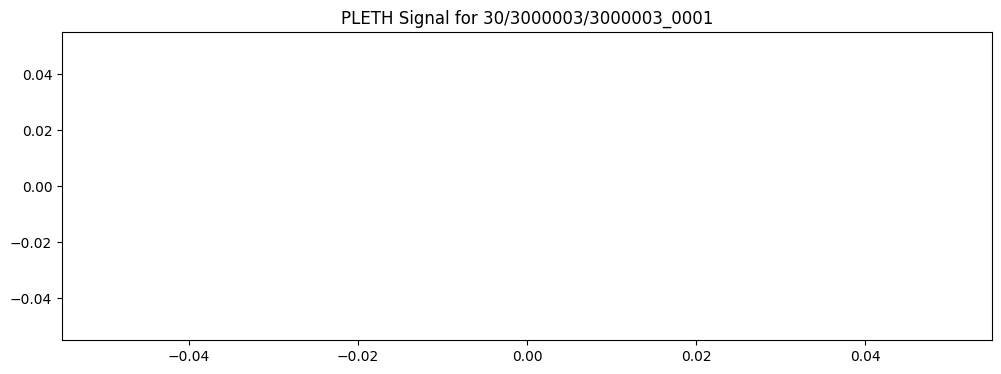

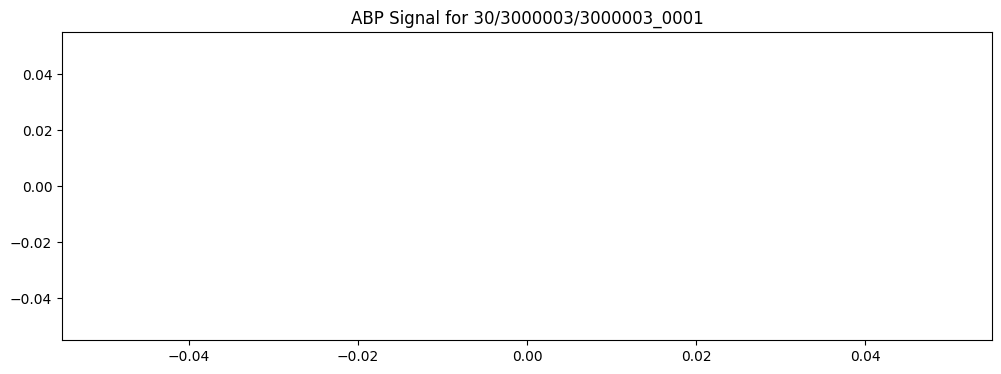

In [ ]:
import urllib.request
import pandas as pd
import wfdb
import os
import matplotlib.pyplot as plt

# Constants
DIR = 30
BASE_URL = f"https://physionet.org/files/mimic3wdb/1.0/{DIR}/RECORDS"

def fetch_records(url):
    """Fetch the RECORDS file content from the URL."""
    try:
        with urllib.request.urlopen(url) as response:
            return [line.decode('utf-8').strip() for line in response.readlines()]
    except Exception as e:
        print(f"Error fetching records from {url}: {e}")
        return []

def extract_numbers(lines):
    """Extract numeric IDs from a list of lines."""
    return [int("".join(filter(str.isdigit, line))) for line in lines]

def process_patient_list(patient_list, limit=10):
    """Process a limited number of patients and fetch their records."""
    plist = []
    for rec in patient_list[:limit]:  # Limit to first 10 patients
        patient_dir = f"{DIR}/{rec}"
        patient_url = f"https://physionet.org/files/mimic3wdb/1.0/{patient_dir}/RECORDS"

        try:
            records = fetch_records(patient_url)
            plist.extend([f"{patient_dir}/{record}" for record in records])
        except Exception as e:
            print(f"Error fetching patient records for {rec}: {e}")

    return plist

def process_signals_and_numerics(patient_records):
    """Split patient records into signal and numeric data."""
    signals = [rec for rec in patient_records if "_" in rec]
    numerics = [rec for rec in patient_records if rec.endswith('n')]
    return signals, numerics

def fetch_and_plot_data(signal, numeric, patient_dir):
    """Fetch and process signal and numeric data, then plot."""
    try:
        # Fetch signal data
        signal_data, signal_fields = wfdb.rdsamp(
            f"mimic3wdb/{signal}", pn_dir=f"mimic3wdb/{patient_dir}", channel_names=["PLETH", "ABP"]
        )
        print(f"Fetched signal data for {signal}")

        # Fetch numeric data
        numeric_data, numeric_fields = wfdb.rdsamp(
            f"mimic3wdb/{numeric}", pn_dir=f"mimic3wdb/{patient_dir}", channel_names=["HR", "ABP Sys", "ABP Dias", "ABP Mean"]
        )
        print(f"Fetched numeric data for {numeric}")

        # Convert signals to DataFrame for plotting
        df_signals = pd.DataFrame(signal_data, columns=["PLETH", "ABP"])

        # Plot signal
        plt.figure(figsize=(12, 4))
        plt.title(f"PLETH Signal for {signal}")
        plt.plot(df_signals["PLETH"])
        plt.show()

        plt.figure(figsize=(12, 4))
        plt.title(f"ABP Signal for {signal}")
        plt.plot(df_signals["ABP"])
        plt.show()

        return signal_data, numeric_data

    except Exception as e:
        print(f"Error processing data for {signal} and {numeric}: {e}")
        return None, None

# Main Execution
if __name__ == "__main__":
    # Fetch all records
    all_records = fetch_records(BASE_URL)
    patient_list = extract_numbers(all_records)

    print(f"Total patients: {len(patient_list)}")
    print(f"Patient IDs: {patient_list[:10]}")

    # Process the first 10 patients
    patient_records = process_patient_list(patient_list, limit=10)
    print(patient_records)
    print(f"Total records fetched: {len(patient_records)}")

    # Split into signals and numerics
    signals, numerics = process_signals_and_numerics(patient_records)
    print(f"Signals: {signals[:5]}")
    print(f"Numerics: {numerics[:5]}")

    # Process and plot data for the first patient
    if signals and numerics:
        fetch_and_plot_data(signals[0], numerics[0], f"{DIR}/{patient_list[0]}")


In [ ]:
import urllib.request
import pandas as pd
import wfdb
import os
import matplotlib.pyplot as plt
from scipy.signal import cheby2, butter, filtfilt
import numpy as np

# Constants
DIR = 30
BASE_URL = f"https://physionet.org/files/mimic3wdb/1.0/{DIR}/RECORDS"

def fetch_records(url):
    """Fetch the RECORDS file content from the URL."""
    try:
        with urllib.request.urlopen(url) as response:
            return [line.decode('utf-8').strip() for line in response.readlines()]
    except Exception as e:
        print(f"Error fetching records from {url}: {e}")
        return []

def extract_numbers(lines):
    """Extract numeric IDs from a list of lines."""
    return [int("".join(filter(str.isdigit, line))) for line in lines]

def process_patient_list(patient_list):
    """Process a limited number of patients and fetch their records."""
    plist = []
    for rec in patient_list:  # Limit to first 10 patients
        patient_dir = f"{DIR}/{rec}"
        patient_url = f"https://physionet.org/files/mimic3wdb/1.0/{patient_dir}/RECORDS"

        try:
            records = fetch_records(patient_url)
            plist.extend([f"{patient_dir}/{record}" for record in records])
        except Exception as e:
            print(f"Error fetching patient records for {rec}: {e}")

    return plist

def process_signals_and_numerics(patient_records):
    """Split patient records into signal and numeric data."""
    signals = [rec for rec in patient_records if "_" in rec]
    numerics = [rec for rec in patient_records if rec.endswith('n')]
    return signals, numerics


def is_valid_signals(ppg_signal, abp_signal, fs, duration=5, sub_window_duration=20, tolerance=0.0):
    """
    Check if both PPG and ABP signals have a clean aligned 5-minute interval.
    - Splits the window into sub-windows (default: 20 seconds).
    - Rejects the entire 5-minute window if any sub-window is a flatline.

    Parameters:
    - ppg_signal: The PPG signal array.
    - abp_signal: The ABP signal array.
    - fs: Sampling frequency (in Hz).
    - duration: Total duration of the window to check (in minutes).
    - sub_window_duration: Duration of each sub-window (in seconds).
    - tolerance: Float, permissible deviation for flatline detection.

    Returns:
    - (bool, tuple): (Validity of window, (start_idx, end_idx) of the valid window)
    """
    min_samples = duration * 60 * fs
    sub_window_samples = sub_window_duration * fs

    if len(ppg_signal) < min_samples or len(abp_signal) < min_samples:
        return False, None

    for start_idx in range(0, len(ppg_signal) - min_samples + 1, fs * 60):  # Slide 1-minute steps
        ppg_window = ppg_signal[start_idx : start_idx + min_samples]
        abp_window = abp_signal[start_idx : start_idx + min_samples]

        # Divide into sub-windows and check for flatlines
        is_valid = True
        for sub_start in range(0, min_samples, sub_window_samples):
            ppg_sub = ppg_window[sub_start : sub_start + sub_window_samples]
            abp_sub = abp_window[sub_start : sub_start + sub_window_samples]

            if (
                np.std(ppg_sub) <= tolerance or np.std(abp_sub) <= tolerance or
                np.isnan(ppg_sub).any() or np.isnan(abp_sub).any()
            ):
                is_valid = False
                break

        if is_valid:
            return True, (start_idx, start_idx + min_samples)

    return False, None

def chebyshev_filter(signal, fs, lowcut, highcut, order=4):
    """4th Order Chebyshev-II Bandpass Filter"""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = cheby2(order, 20, [low, high], btype='bandpass', output='ba')
    return filtfilt(b, a, signal)

def butterworth_filter(signal, fs, lowcut, highcut, order=4):
    """4th Order Butterworth Bandpass Filter"""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='bandpass')
    return filtfilt(b, a, signal)

def normalize_signal(signal):
    """Normalize signal to zero mean and unit variance"""
    return (signal - np.mean(signal)) / np.std(signal)

def hampel_filter(signal, window_size, threshold=3):
    """Remove outliers using Hampel filter"""
    n = len(signal)
    signal_filtered = signal.copy()
    for i in range(window_size, n - window_size):
        window = signal[i - window_size:i + window_size + 1]
        median = np.median(window)
        mad = np.median(np.abs(window - median))
        if mad == 0:
            continue
        if abs(signal[i] - median) / mad > threshold:
            signal_filtered[i] = median
    return signal_filtered

def filter_abp(abp_signal, sbp_limits=(80, 180), dbp_limits=(60, 130)):
    """Filter out-of-range ABP values"""
    sbp, dbp = abp_signal[:, 0], abp_signal[:, 1]
    mask = (sbp_limits[0] <= sbp) & (sbp <= sbp_limits[1]) & \
           (dbp_limits[0] <= dbp) & (dbp <= dbp_limits[1])
    return abp_signal[mask]

# Main Preprocessing Function
def preprocess_signals(abp_signal, ppg_signal, fs):
    # 1. Filter out-of-range ABP values
    filtered_abp = filter_abp(np.column_stack((abp_signal, abp_signal)))

    # 2. Apply Chebyshev-II filter
    chebyshev_filtered_abp = chebyshev_filter(filtered_abp[:, 0], fs, 0.5, 8)
    chebyshev_filtered_ppg = chebyshev_filter(ppg_signal, fs, 0.5, 8)

    # 3. Normalize PPG signal
    normalized_ppg = normalize_signal(chebyshev_filtered_ppg)

    # 4. Apply Butterworth filter
    butterworth_filtered_abp = butterworth_filter(chebyshev_filtered_abp, fs, 0.5, 8)
    butterworth_filtered_ppg = butterworth_filter(normalized_ppg, fs, 0.5, 8)

    # 5. Apply Hampel filter for outlier removal
    hampel_filtered_abp = hampel_filter(butterworth_filtered_abp, window_size=10)
    hampel_filtered_ppg = hampel_filter(butterworth_filtered_ppg, window_size=10)

    return hampel_filtered_abp, hampel_filtered_ppg

def align_signals(ppg_signal, abp_signal):
    """
    Align PPG and ABP signals using cross-correlation.
    """
    # Compute cross-correlation
    correlation = np.correlate(ppg_signal, abp_signal, mode='full')
    lag = np.argmax(correlation) - len(abp_signal) + 1

    # Align signals
    if lag > 0:
        aligned_ppg = ppg_signal[lag:]
        aligned_abp = abp_signal[:len(aligned_ppg)]
    elif lag < 0:
        aligned_abp = abp_signal[-lag:]
        aligned_ppg = ppg_signal[:len(aligned_abp)]
    else:
        aligned_ppg, aligned_abp = ppg_signal, abp_signal

    return aligned_ppg, aligned_abp, lag


def process_signals_for_one_patient(patient_id, signals, fs=125, duration=5):
    """
    Process all signals for a single patient.
    Returns the first clean 5-minute aligned segment for both PPG and ABP signals if found.
    """
    for signal_path in signals:
        try:
            #analyzing model by extracting a single patient record
            signals, fields = wfdb.rdsamp(f"mimic3wdb/{signal_path}",
                              pn_dir=f"mimic3wdb/{DIR}/{patient_id}",
                                     channel_names = ["PLETH", "ABP"])

            # Check for required signals and sampling frequency
            if fields["fs"] != fs or "PLETH" not in fields["sig_name"] or "ABP" not in fields["sig_name"]:
                continue

            ppg_idx = fields["sig_name"].index("PLETH")
            abp_idx = fields["sig_name"].index("ABP")

            ppg_signal = signals[:, ppg_idx]
            abp_signal = signals[:, abp_idx]

            processed_abp, processed_ppg = preprocess_signals(abp_signal, ppg_signal, fs)

            # Align the signals using cross-correlation
            ppg_aligned, abp_aligned, lag = align_signals(processed_ppg, processed_abp)
            print(f"Signals aligned with lag of {lag} samples.")

            # Check if there's a valid aligned 5-minute interval
            valid, window = is_valid_signals(ppg_aligned, abp_aligned, fs, duration)
            if valid:
                start, end = window
                print(f"Valid 5-minute interval found for {record_name}.")
                return ppg_aligned[start:end], abp_aligned[start:end]

        except Exception as e:
            print(f"Error processing signal {signal_path}: {e}")
            continue

    return None, None


def main():
    # Fetch all records
    all_records = fetch_records(BASE_URL)
    patient_list = extract_numbers(all_records)
    print(f"Total patients: {len(patient_list)}")

    # Pre-group signals by patient ID
    patient_records = process_patient_list(patient_list)
    signals, numerics = process_signals_and_numerics(patient_records)
    grouped_signals = {patient_id: [sig for sig in signals if f"/{patient_id}/" in sig] for patient_id in patient_list}

    # Prepare output dataset
    combined_data = []
    patient_count = 0
    MAX_PATIENTS = 90

    for patient_id, patient_signals in grouped_signals.items():
        print(f"Processing patient: {patient_id}")

        # Skip if no valid signals
        if not patient_signals:
            print(f"No valid signals for patient {patient_id}")
            continue

        # Get valid PPG and ABP segments
        ppg_segment, abp_segment = process_signals_for_one_patient(patient_id, patient_signals)

        if ppg_segment is not None and abp_segment is not None:
            for i in range(len(ppg_segment)):
                combined_data.append({
                    "Patient ID": patient_id,
                    "PPG": ppg_segment[i],
                    "ABP": abp_segment[i]
                })
            patient_count += 1
            print(f"Valid 5-minute segment saved for patient {patient_id}")

        if patient_count == MAX_PATIENTS:
            break

    OUTPUT_FILE = "clean_ppg_abp_segments.csv"

    # Save combined dataset to a CSV file
    if combined_data:
        df = pd.DataFrame(combined_data)
        df.to_csv(OUTPUT_FILE, index=False)
        print(f"Saved data for {patient_count} patients to {OUTPUT_FILE}")
    else:
        print("No valid data to save.")

if __name__ == "__main__":
    main()


signal after extraction



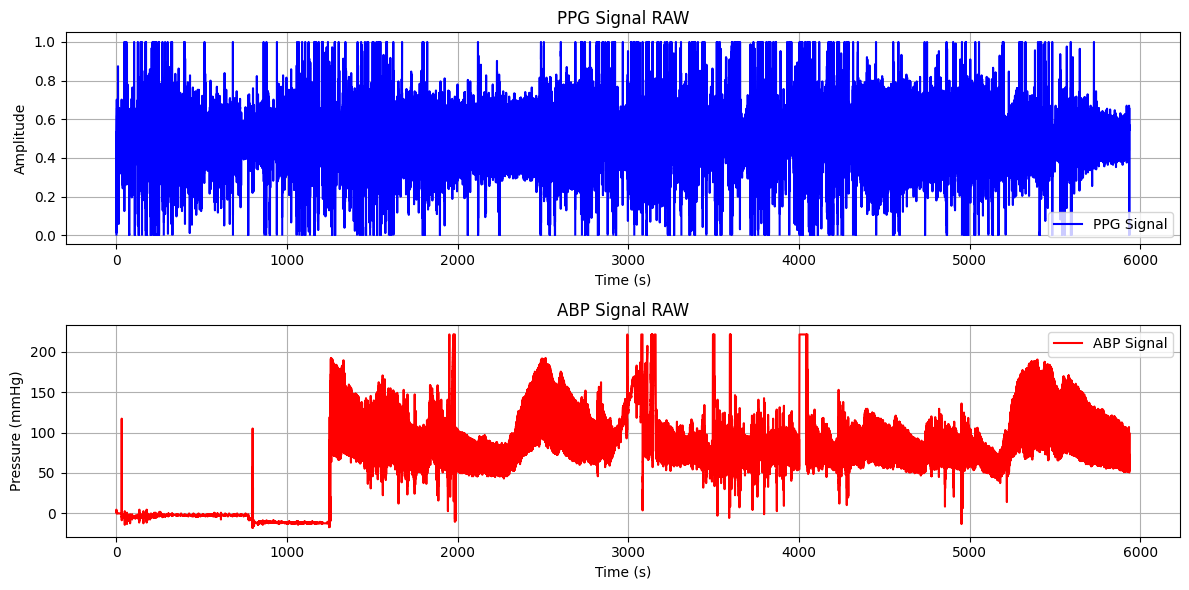

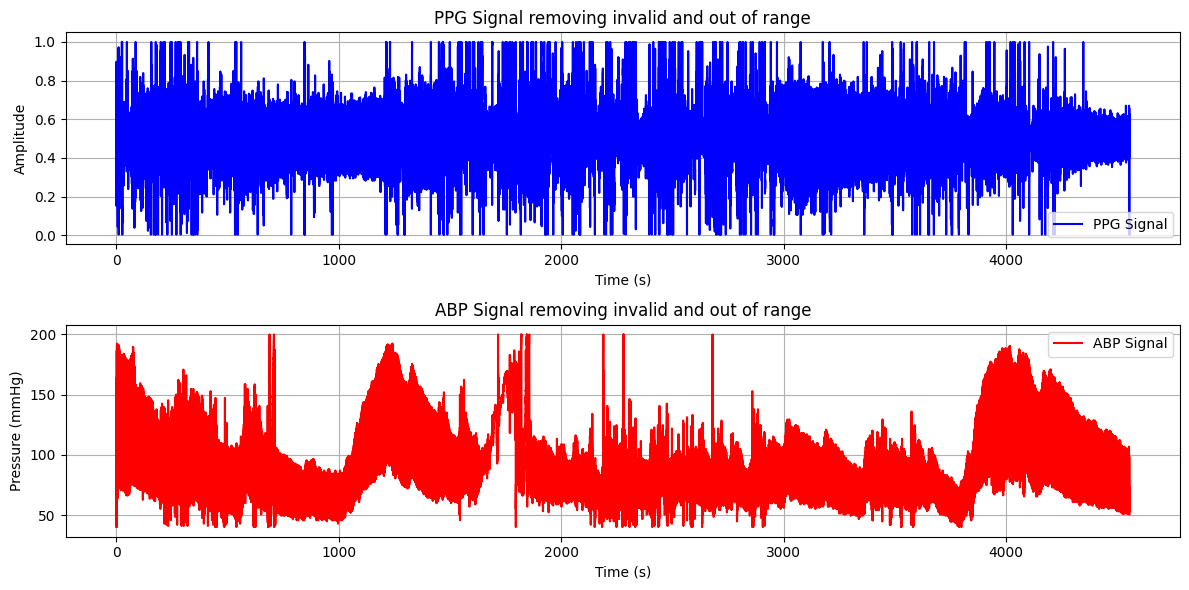

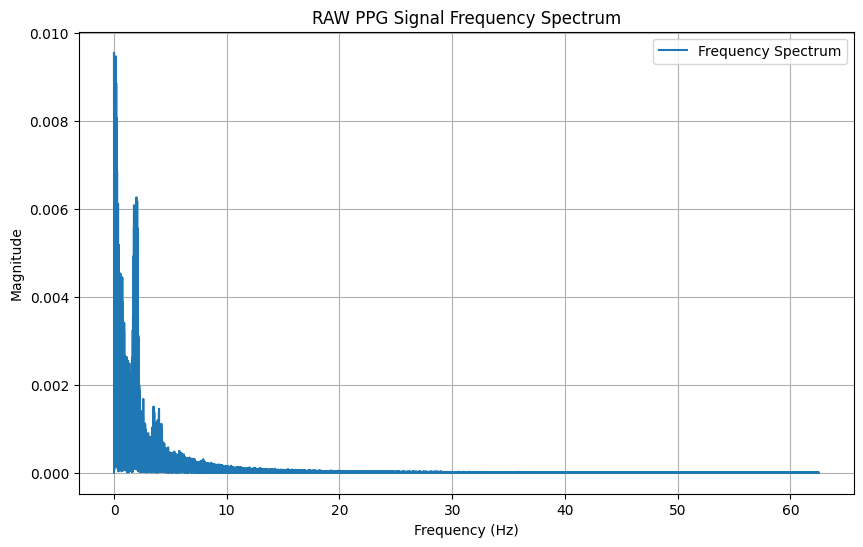

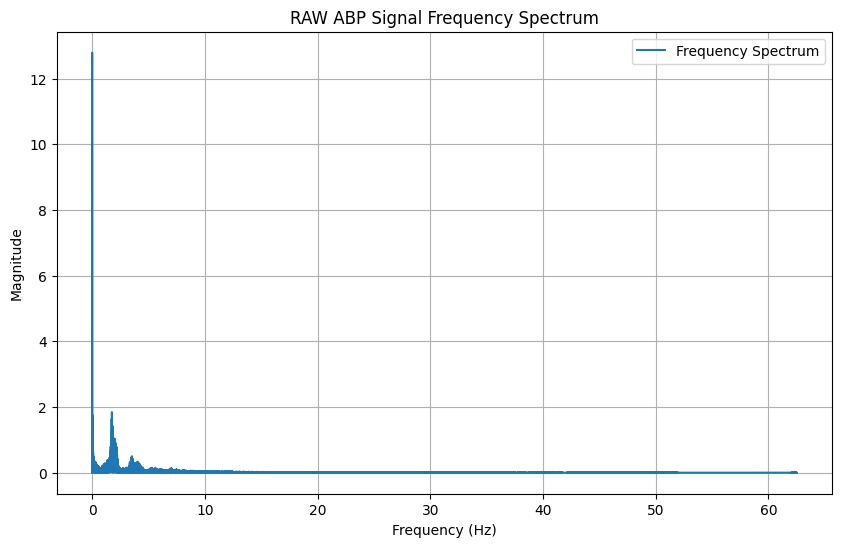

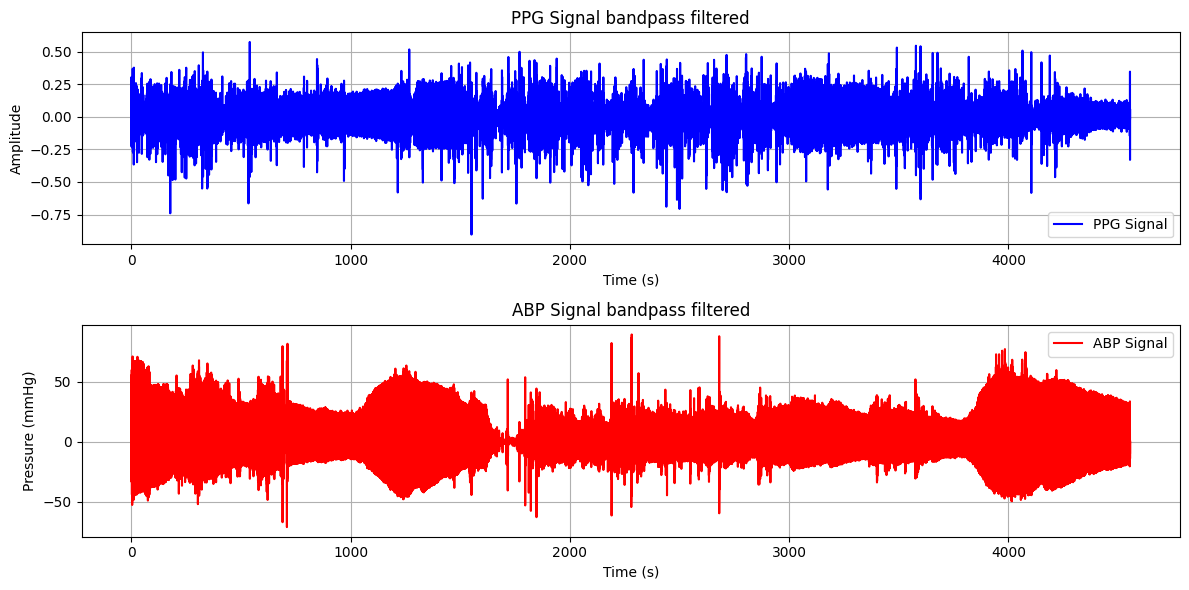

signal after filtering




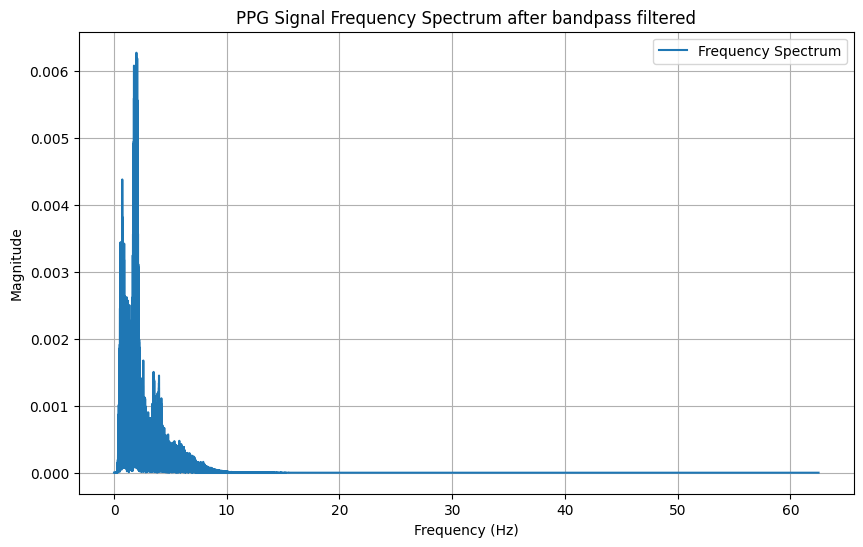

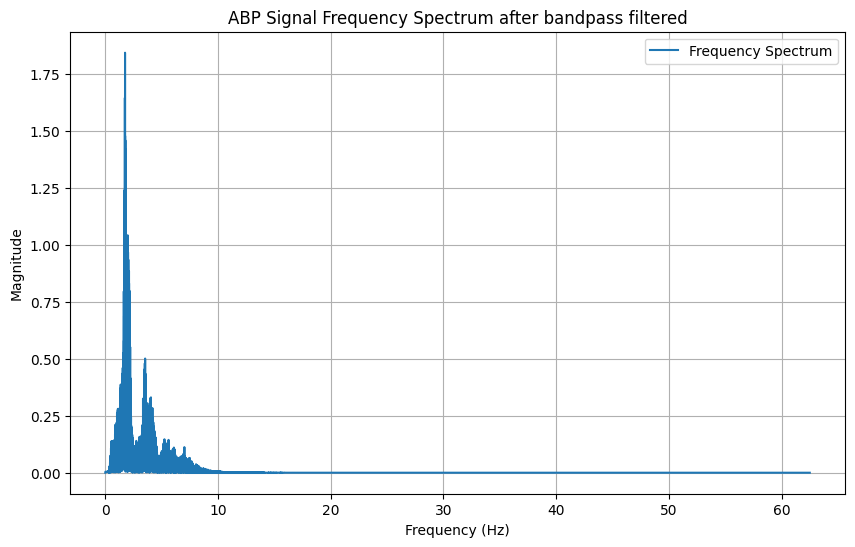

Count of hampel filter changes: 1

Count of hampel filter changes: 8



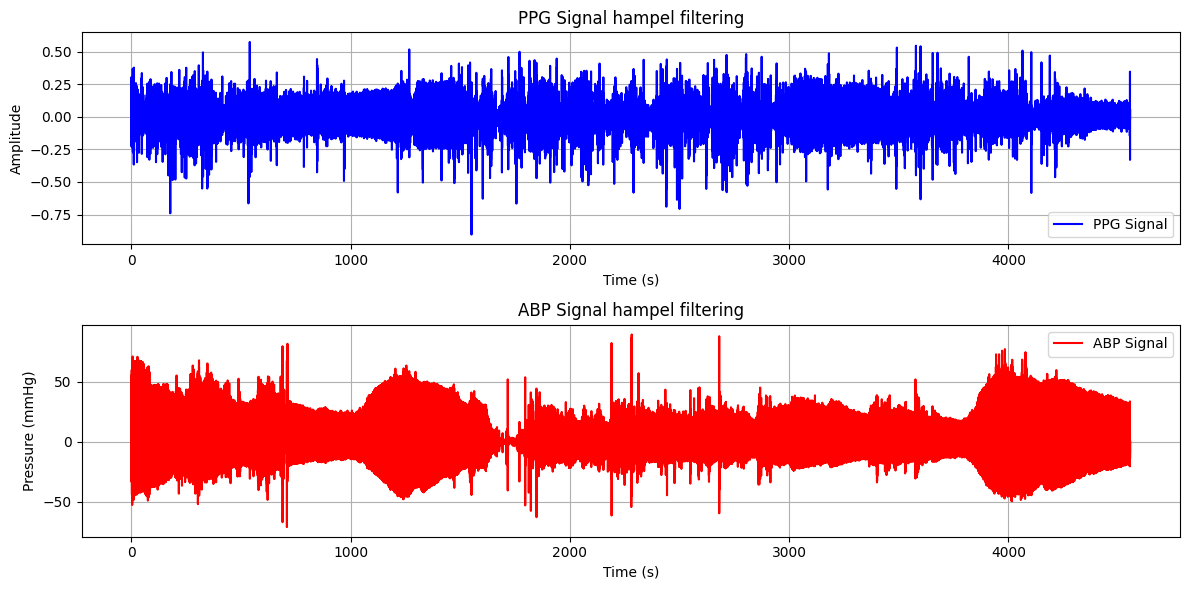

signal after hampel filtering




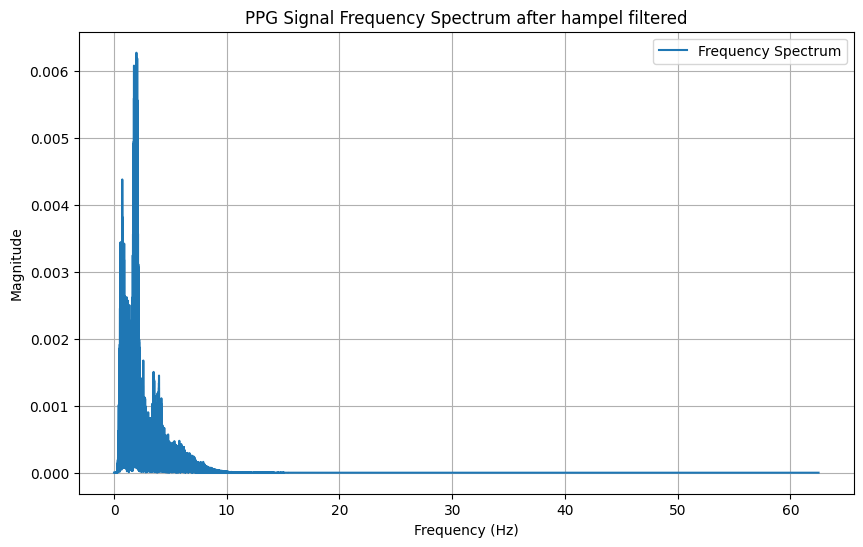

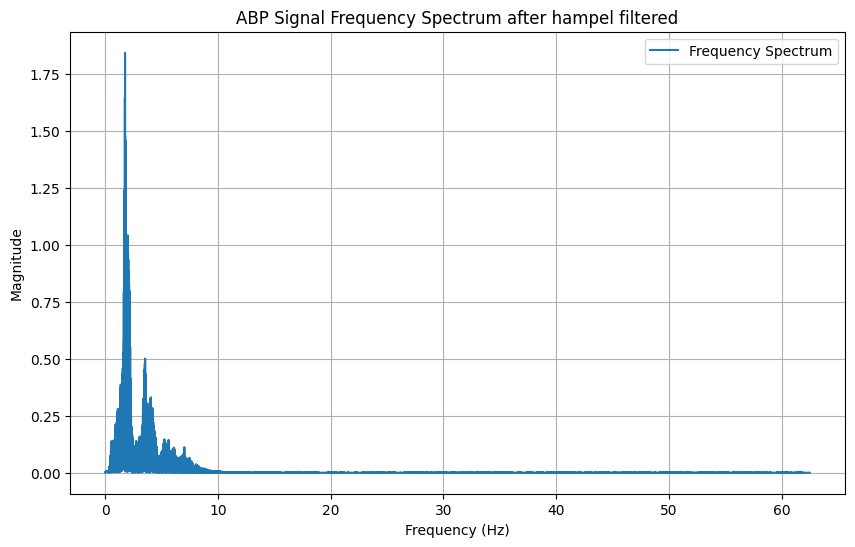

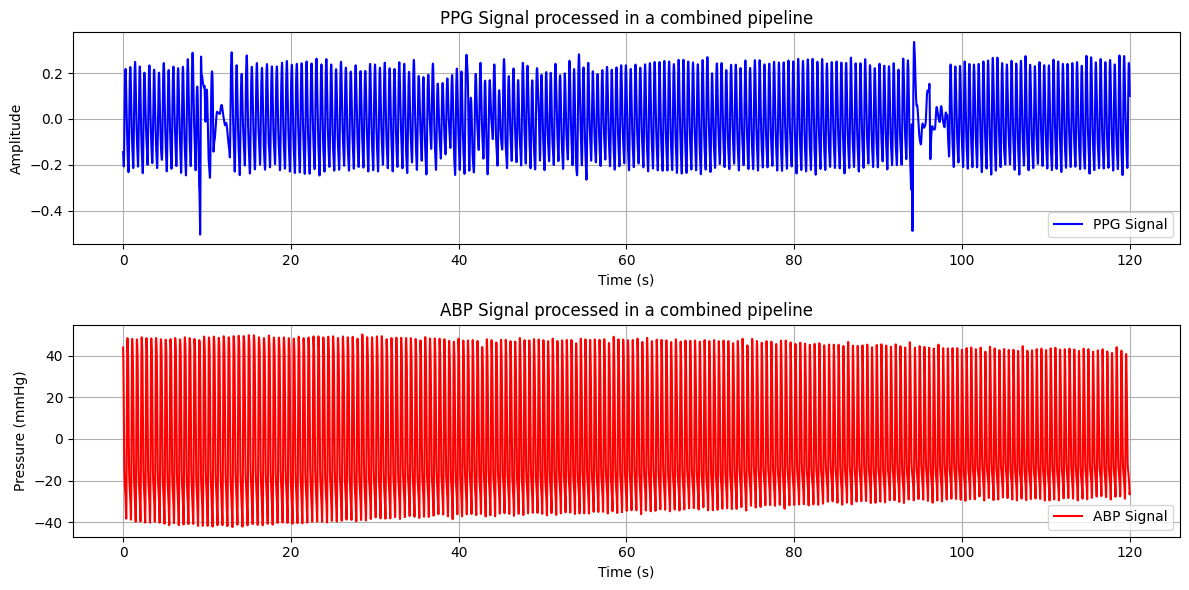

In [17]:
#import libraries
import io
import os
import pandas as pd
import numpy as np
import wfdb
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks, correlate

def is_valid_signals(ppg_signal, abp_signal, fs, duration=2, sub_window_duration=5, tolerance=0.0):
    """
    Check if both PPG and ABP signals have a clean aligned 5-minute interval.
    - Splits the window into sub-windows (default: 20 seconds).
    - Rejects the entire 5-minute window if any sub-window is a flatline.
    - Ensures ABP signal is within a physiologically valid range [40, 200] mmHg.

    Parameters:
    - ppg_signal: The PPG signal array.
    - abp_signal: The ABP signal array.
    - fs: Sampling frequency (in Hz).
    - duration: Total duration of the window to check (in minutes).
    - sub_window_duration: Duration of each sub-window (in seconds).
    - tolerance: Float, permissible deviation for flatline detection.

    Returns:
    - (bool, tuple): (Validity of window, (start_idx, end_idx) of the valid window)
    """
    min_samples = duration * 60 * fs
    sub_window_samples = sub_window_duration * fs

    if len(ppg_signal) < min_samples or len(abp_signal) < min_samples:
        return False, None

    for start_idx in range(0, len(ppg_signal) - min_samples + 1, fs * 20):  # Slide 20 sec steps
        ppg_window = ppg_signal[start_idx : start_idx + min_samples]
        abp_window = abp_signal[start_idx : start_idx + min_samples]

        # Divide into sub-windows and check for flatlines
        is_valid = True
        for sub_start in range(0, min_samples, sub_window_samples):
            ppg_sub = ppg_window[sub_start : sub_start + sub_window_samples]
            abp_sub = abp_window[sub_start : sub_start + sub_window_samples]

            if (
                np.std(ppg_sub) <= tolerance or np.std(abp_sub) <= tolerance or
                np.isnan(ppg_sub).any() or np.isnan(abp_sub).any()
            ):
                is_valid = False
                break

        if is_valid:
            return True, (start_idx, start_idx + min_samples)

    return False, None


def plot_frequency_spectrum(signal, sampling_rate, title="Frequency Content"):

    scaled_signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))  # Min-max normalization
    # Remove DC component
    signal_dc_removed = signal - np.mean(signal)

    # FFT
    n = len(signal_dc_removed)
    freq = fftfreq(n, d=1/sampling_rate)[:n//2]  # Positive frequencies
    fft_values = fft(signal_dc_removed)
    magnitude = 2.0 / n * np.abs(fft_values[:n//2])

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(freq, magnitude, label="Frequency Spectrum")
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.legend()
    plt.show()

def remove_invalid_values(ppg_signal, abp_signal):
    """
    Remove NaN and infinite values from both PPG and ABP signals, ensuring alignment.

    Parameters:
    - ppg_signal: The PPG signal array (NumPy array).
    - abp_signal: The ABP signal array (NumPy array).

    Returns:
    - cleaned_ppg: Cleaned PPG signal with invalid values removed.
    - cleaned_abp: Cleaned ABP signal with corresponding indices removed.
    """
    # Create a mask for valid (finite) values in both signals
    valid_mask = (
        np.isfinite(ppg_signal) &  # PPG signal has no NaN or Inf
        np.isfinite(abp_signal)    # ABP signal has no NaN or Inf
    )

    # Apply the mask to both signals
    cleaned_ppg = ppg_signal[valid_mask]
    cleaned_abp = abp_signal[valid_mask]

    return cleaned_ppg, cleaned_abp

def remove_out_of_range_bp(ppg_signal, abp_signal, min_bp=40, max_bp=200):
    """
    Remove ABP values outside the range [min_bp, max_bp], and remove the corresponding PPG signal values.

    Parameters:
    - ppg_signal: The PPG signal array (NumPy array).
    - abp_signal: The ABP signal array (NumPy array).
    - min_bp: Minimum allowable blood pressure value (default: 40 mmHg).
    - max_bp: Maximum allowable blood pressure value (default: 200 mmHg).

    Returns:
    - cleaned_ppg: Cleaned PPG signal with out-of-range values removed.
    - cleaned_abp: Cleaned ABP signal with out-of-range values removed.
    """
    # Create a mask for ABP values within the valid range
    valid_mask = (abp_signal >= min_bp) & (abp_signal <= max_bp)

    # Apply the mask to both signals
    cleaned_ppg = ppg_signal[valid_mask]
    cleaned_abp = abp_signal[valid_mask]

    return cleaned_ppg, cleaned_abp

def detect_peaks(signal, distance, prominence):
    """
    Detect peaks in a signal.
    Parameters:
    - signal: Input signal (NumPy array).
    - distance: Minimum distance between peaks.
    - prominence: Minimum prominence of peaks.
    Returns:
    - peaks: Indices of detected peaks.
    """
    peaks, _ = find_peaks(signal, distance=distance, prominence=prominence)
    return peaks

def cross_correlation(ppg_peaks, abp_peaks, fs):
    """
    Compute cross-correlation between detected peaks in PPG and ABP signals.
    Parameters:
    - ppg_peaks: Indices of detected PPG peaks.
    - abp_peaks: Indices of detected ABP peaks.
    - fs: Sampling frequency.
    Returns:
    - lag: Computed lag (in seconds).
    """
    # Convert indices to time
    ppg_time = ppg_peaks / fs
    abp_time = abp_peaks / fs

    # Interpolate signals for cross-correlation
    cross_corr = correlate(ppg_time, abp_time, mode='full')
    lag_samples = np.argmax(cross_corr) - (len(abp_time) - 1)
    lag = lag_samples / fs
    return lag

def align_signals(signal1, signal2, lag, fs):
    """
    Align two signals based on the computed lag.
    Parameters:
    - signal1: The first signal (e.g., PPG).
    - signal2: The second signal (e.g., ABP).
    - lag: Computed lag in seconds.
    - fs: Sampling frequency in Hz.
    Returns:
    - aligned_signal1, aligned_signal2: Synchronized signals.
    """
    lag_samples = int(lag * fs)
    if lag_samples > 0:
        # PPG lags behind ABP
        aligned_signal1 = signal1[lag_samples:]
        aligned_signal2 = signal2[:-lag_samples]
    else:
        # ABP lags behind PPG
        aligned_signal1 = signal1[:lag_samples]
        aligned_signal2 = signal2[-lag_samples:]

    return aligned_signal1, aligned_signal2

def find_peaks_and_max_correlation(ppg_signal, abp_signal, fs, segment_duration=2, overlap=1, peak_distance=50):
    """
    Find the window with the highest correlation between PPG and ABP peaks.

    Parameters:
    - ppg_signal: PPG signal (NumPy array).
    - abp_signal: ABP signal (NumPy array).
    - fs: Sampling frequency (Hz).
    - segment_duration: Duration of each segment (in minutes).
    - overlap: Overlap between consecutive segments (in minutes).
    - peak_distance: Minimum distance between consecutive peaks (in samples).

    Returns:
    - best_ppg_segment: PPG signal segment with the highest correlation.
    - best_abp_segment: ABP signal segment with the highest correlation.
    - max_corr: Maximum correlation value.
    """
    segment_samples = int(segment_duration * 60 * fs)
    overlap_samples = int(overlap * 60 * fs)
    step_size = segment_samples - overlap_samples

    max_corr = -np.inf
    best_ppg_segment = None
    best_abp_segment = None

    # Iterate over the signal with sliding windows
    for start_idx in range(0, len(ppg_signal) - segment_samples + 1, step_size):
        end_idx = start_idx + segment_samples

        # Extract windowed signals
        ppg_segment = ppg_signal[start_idx:end_idx]
        abp_segment = abp_signal[start_idx:end_idx]

        # Detect peaks in the PPG and ABP signals
        ppg_peaks, _ = find_peaks(ppg_segment, distance=peak_distance)
        abp_peaks, _ = find_peaks(abp_segment, distance=peak_distance)

        # Extract peak values for cross-correlation
        ppg_peak_values = ppg_segment[ppg_peaks]
        abp_peak_values = abp_segment[abp_peaks]

        # Compute cross-correlation of the peaks
        if len(ppg_peak_values) > 1 and len(abp_peak_values) > 1:
            correlation = correlate(ppg_peak_values, abp_peak_values, mode="valid")
            max_corr_in_window = np.max(correlation)

            # Update if this window has the highest correlation
            if max_corr_in_window > max_corr:
                max_corr = max_corr_in_window
                best_ppg_segment = ppg_segment
                best_abp_segment = abp_segment

    return best_ppg_segment, best_abp_segment, max_corr




def process_signals_for_one_patient(patient_id, signals, fs=125, duration=2):
    """
    Process all signals for a single patient.
    Returns the first clean 5-minute aligned segment for both PPG and ABP signals if found.
    """
    for signal_path in signals:
        try:
            #analyzing model by extracting a single patient record
            signals, fields = wfdb.rdsamp('mimic3wdb/30/3000063/3000063_0006',
                              pn_dir='mimic3wdb/30/3000063',
                                     channel_names = ["PLETH", "ABP"])

            # Check for required signals and sampling frequency
            if fields["fs"] != fs or "PLETH" not in fields["sig_name"] or "ABP" not in fields["sig_name"]:
                continue

            ppg_idx = fields["sig_name"].index("PLETH")
            abp_idx = fields["sig_name"].index("ABP")

            ppg_signal = signals[:, ppg_idx]
            abp_signal = signals[:, abp_idx]

            print("signal after extraction\n")
            plot_signals(ppg_signal, abp_signal, "RAW", fs=125)

            ppg_signal, abp_signal = remove_invalid_values(ppg_signal, abp_signal)

            ppg_signal, abp_signal = remove_out_of_range_bp(ppg_signal, abp_signal)

            plot_signals(ppg_signal, abp_signal, "removing invalid and out of range", fs=125)

            plot_frequency_spectrum(ppg_signal, fs=125, title="RAW PPG Signal Frequency Spectrum")
            plot_frequency_spectrum(abp_signal, fs=125, title="RAW ABP Signal Frequency Spectrum")


            ppg_signal = bandpass_filter(ppg_signal, fs=125)
            abp_signal = bandpass_filter(abp_signal, fs=125)

            plot_signals(ppg_signal, abp_signal, "bandpass filtered", fs=125)

            print("signal after filtering\n\n")
            plot_frequency_spectrum(ppg_signal, fs=125, title="PPG Signal Frequency Spectrum after bandpass filtered")
            plot_frequency_spectrum(abp_signal, fs=125, title="ABP Signal Frequency Spectrum after bandpass filtered")

            # Apply Hampel filtering
            ppg_signal = hampel_filter(ppg_signal, window_size=10, threshold=3)
            abp_signal = hampel_filter(abp_signal, window_size=10, threshold=3)

            plot_signals(ppg_signal, abp_signal, "hampel filtering", fs=125)

            print("signal after hampel filtering\n\n")
            plot_frequency_spectrum(ppg_signal, fs=125, title="PPG Signal Frequency Spectrum after hampel filtered")
            plot_frequency_spectrum(abp_signal, fs=125, title="ABP Signal Frequency Spectrum after hampel filtered")

            fs = 125  # Sampling frequency in Hz
            segment_duration = 2  # 2 minutes
            overlap = 1  # 1-minute overlap
            peak_distance = int(0.5 * fs)  # Minimum distance between peaks (0.5 seconds)
            ppg_signal, abp_signal, max_corr = find_peaks_and_max_correlation(
                        ppg_signal, abp_signal, fs, segment_duration, overlap, peak_distance
                    )

            return ppg_signal, abp_signal

        except Exception as e:
            print(f"Error processing signal {signal_path}: {e}")
            continue

    return None, None

def bandpass_filter(signal, fs, low_cutoff=0.5, high_cutoff=8.0, order=4):
    """
    Apply a Butterworth bandpass filter to a signal.

    Parameters:
    - signal: Input signal (NumPy array).
    - fs: Sampling frequency in Hz.
    - low_cutoff: Lower cutoff frequency of the filter in Hz.
    - high_cutoff: Upper cutoff frequency of the filter in Hz.
    - order: Order of the Butterworth filter (default: 4).

    Returns:
    - Filtered signal (NumPy array).
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist

    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')

    # Apply filter to the signal using zero-phase filtering
    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal

def hampel_filter(signal, window_size=5, threshold=3):
    """
    Apply Hampel filter to remove outliers.
    - signal: Input signal array.
    - window_size: Size of the moving window (in samples).
    - threshold: Threshold for detecting outliers (in MAD units).
    """
    count = 0
    n = len(signal)
    filtered_signal = signal.copy()
    for i in range(window_size, n - window_size):
        window = signal[i - window_size:i + window_size + 1]
        median = np.median(window)
        mad = np.median(np.abs(window - median))
        if mad == 0:
            continue
        if np.abs(signal[i] - median) > threshold * mad:
            filtered_signal[i] = median
            count=count+1

    print(f"Count of hampel filter changes: {count}\n")
    return filtered_signal

def plot_signals(ppg_segment, abp_segment, label, fs=125):
    """
    Plot PPG and ABP signals.
    - ppg_segment: Extracted PPG signal.
    - abp_segment: Extracted ABP signal.
    - fs: Sampling frequency (default: 125 Hz).
    """
    time = np.arange(0, len(ppg_segment)) / fs  # Create time axis in seconds

    # Plot PPG Signal
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, ppg_segment, label="PPG Signal", color='blue')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"PPG Signal {label}")
    plt.grid()
    plt.legend()

    # Plot ABP Signal
    plt.subplot(2, 1, 2)
    plt.plot(time, abp_segment, label="ABP Signal", color='red')
    plt.xlabel("Time (s)")
    plt.ylabel("Pressure (mmHg)")
    plt.title(f"ABP Signal {label}")
    plt.grid()
    plt.legend()

    # Show Plots
    plt.tight_layout()
    plt.show()

def plot_frequency_spectrum(signal, fs, title="Frequency Spectrum"):
    """
    Compute and plot the frequency spectrum of a signal.

    Parameters:
    - signal: Input signal (NumPy array).
    - fs: Sampling frequency in Hz.
    - title: Title for the plot.
    """
    # Remove DC component
    signal_dc_removed = signal - np.mean(signal)

    # FFT
    n = len(signal_dc_removed)
    freq = fftfreq(n, d=1/fs)[:n//2]  # Positive frequencies
    fft_values = fft(signal_dc_removed)
    magnitude = 2.0 / n * np.abs(fft_values[:n//2])

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(freq, magnitude, label="Frequency Spectrum")
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.legend()
    plt.show()

def main():
      patient_id = 3000003
      signals_data = [
            "30/3000063/3000063_0006"
        ]

      ppg_segment, abp_segment = process_signals_for_one_patient(patient_id, signals_data)

      plot_signals(ppg_segment, abp_segment, "processed in a combined pipeline", fs=125)

if __name__ == "__main__":
    main()


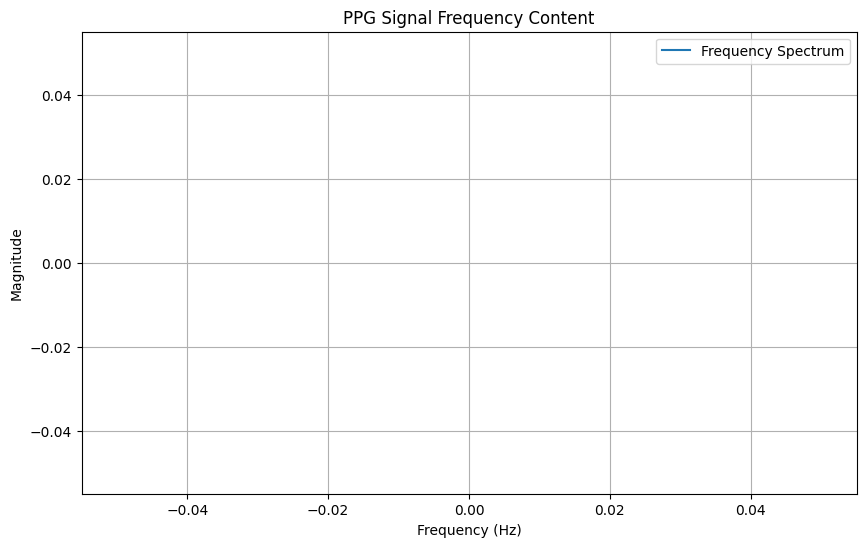

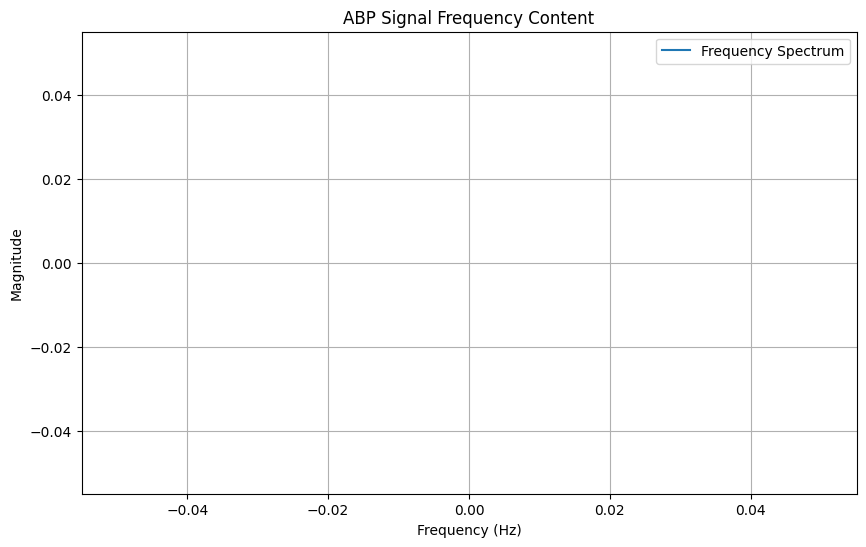

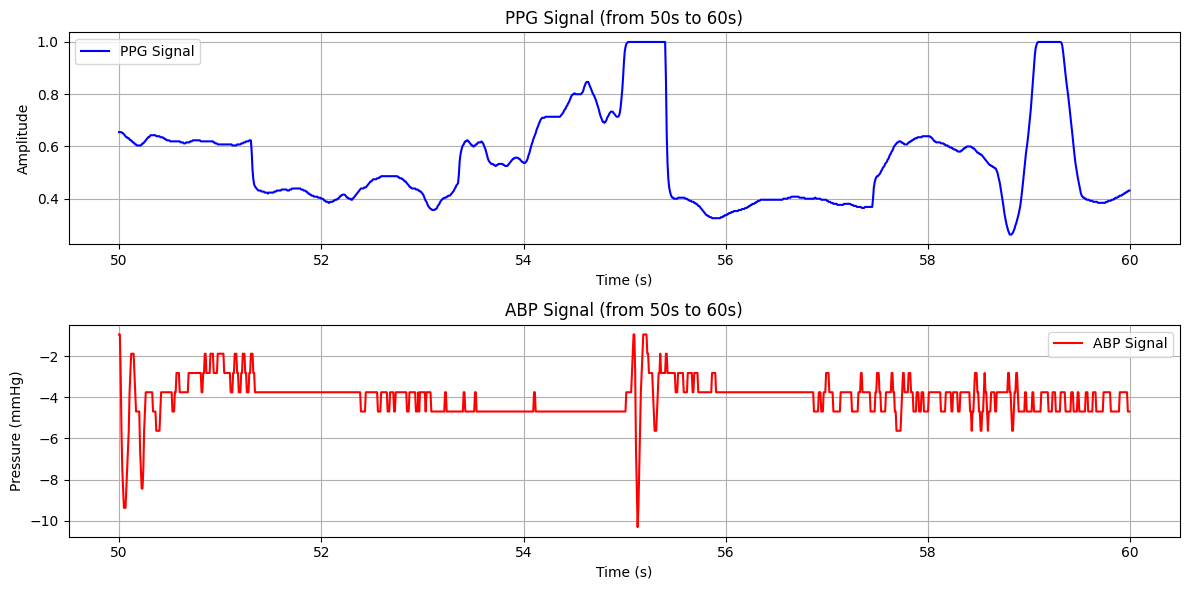

In [ ]:
#import libraries
import io
import os
import pandas as pd
import numpy as np
import wfdb
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
from scipy.stats import zscore

def clip_signal(signal, lower_limit, upper_limit):
    """
    Clip the signal to a physiologically plausible range.
    Parameters:
    - signal: The signal array.
    - lower_limit: Lower bound of the range.
    - upper_limit: Upper bound of the range.
    Returns:
    - Clipped signal.
    """
    return np.clip(signal, lower_limit, upper_limit)

def verify_frequency_content(signal, fs, title="Frequency Content"):
    """
    Analyze and plot the frequency content of a signal using FFT.
    """
    plot_frequency_spectrum(signal, fs, title=title)

def preprocess_signal(signal, fs, cutoff_low=0.5, cutoff_high=8.0, order=4):
    """
    Preprocess the signal by applying a Butterworth bandpass filter.
    Parameters:
    - signal: The signal array.
    - fs: Sampling frequency (in Hz).
    - cutoff_low: Lower cutoff frequency for the filter.
    - cutoff_high: Upper cutoff frequency for the filter.
    - order: Order of the Butterworth filter.
    Returns:
    - Preprocessed signal.
    """
    nyquist = 0.5 * fs
    low = cutoff_low / nyquist
    high = cutoff_high / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def hampel_filter(signal, window_size, threshold=3):
    """Remove outliers using Hampel filter"""
    n = len(signal)
    signal_filtered = signal.copy()
    for i in range(window_size, n - window_size):
        window = signal[i - window_size:i + window_size + 1]
        median = np.median(window)
        mad = np.median(np.abs(window - median))
        if mad == 0:
            continue
        if abs(signal[i] - median) / mad > threshold:
            signal_filtered[i] = median
    return signal_filtered

def interpolate_and_clean(signal, fs, cluster_threshold=0.5):
    """
    Handle NaN and infinite values in the signal using a hybrid strategy:
    - Interpolate sparse invalid values.
    - Remove clusters of invalid values exceeding a time threshold.

    Parameters:
    - signal: The signal array.
    - fs: Sampling frequency (in Hz).
    - cluster_threshold: Threshold for invalid clusters (in seconds).
    Returns:
    - Cleaned signal with no NaN or infinite values.
    """
    signal = np.array(signal)
    invalid_mask = np.isnan(signal) | np.isinf(signal)
    cluster_samples = int(cluster_threshold * fs)

    # Identify clusters of invalid values
    valid_signal = np.copy(signal)
    invalid_clusters = []
    start_idx = None

    for i, invalid in enumerate(invalid_mask):
        if invalid and start_idx is None:
            start_idx = i
        elif not invalid and start_idx is not None:
            if i - start_idx >= cluster_samples:
                invalid_clusters.append((start_idx, i))
            start_idx = None
    if start_idx is not None and len(signal) - start_idx >= cluster_samples:
        invalid_clusters.append((start_idx, len(signal)))

    # Interpolate sparse invalid values
    if invalid_mask.any():
        x = np.arange(len(signal))
        valid_signal[invalid_mask] = np.interp(
            x[invalid_mask], x[~invalid_mask], signal[~invalid_mask]
        )

    # Remove clusters of invalid data
    for start, end in invalid_clusters:
        valid_signal[start:end] = np.nan

    # Return a fully cleaned signal (removing any remaining NaN after interpolation)
    return valid_signal[~np.isnan(valid_signal)]

def normalize_signal(signal):
    """
    Normalize the signal to zero mean and unit variance.

    Parameters:
    - signal: The signal array.
    Returns:
    - Normalized signal.
    """
    return zscore(signal)

def is_valid_signals(
    ppg_signal, abp_signal, fs, duration=2, sub_window_duration=5, tolerance=0.0
):
    """
    Check if both PPG and ABP signals have a clean aligned 5-minute interval.
    - Cleans invalid values using a hybrid strategy.
    - Filters and normalizes signals.
    - Splits the window into sub-windows for validation.

    Parameters:
    - ppg_signal: The PPG signal array.
    - abp_signal: The ABP signal array.
    - fs: Sampling frequency (in Hz).
    - duration: Total duration of the window to check (in minutes).
    - sub_window_duration: Duration of each sub-window (in seconds).
    - tolerance: Float, permissible deviation for flatline detection.

    Returns:
    - (bool, tuple): (Validity of window, (start_idx, end_idx) of the valid window).
    """
    min_samples = duration * 60 * fs
    sub_window_samples = sub_window_duration * fs

    if len(ppg_signal) < min_samples or len(abp_signal) < min_samples:
        return False, None

    # Step 1: Hybrid Cleaning
    ppg_signal = interpolate_and_clean(ppg_signal, fs)
    abp_signal = interpolate_and_clean(abp_signal, fs)

    ppg_signal = clip_signal(ppg_signal, lower_limit=0, upper_limit=10)  # Example PPG range
    abp_signal = clip_signal(abp_signal, lower_limit=40, upper_limit=200)  # Example ABP range

    # Step 2: Filter Signals
    ppg_signal = preprocess_signal(ppg_signal, fs)  # Butterworth filter
    abp_signal = preprocess_signal(abp_signal, fs)

    # Step 3: Remove Outliers with Hampel Filter
    ppg_signal = hampel_filter(ppg_signal, window_size=10)
    abp_signal = hampel_filter(abp_signal, window_size=10)

    # Step 4: Normalize Signals
    ppg_signal = normalize_signal(ppg_signal)
    abp_signal = normalize_signal(abp_signal)

    # Step 5: Check Valid Intervals
    for start_idx in range(0, len(ppg_signal) - min_samples + 1, fs * 60):  # Slide 1-minute steps
        ppg_window = ppg_signal[start_idx : start_idx + min_samples]
        abp_window = abp_signal[start_idx : start_idx + min_samples]

        # Divide into sub-windows and check for flatlines
        is_valid = True
        for sub_start in range(0, min_samples, sub_window_samples):
            ppg_sub = ppg_window[sub_start : sub_start + sub_window_samples]
            abp_sub = abp_window[sub_start : sub_start + sub_window_samples]
            if (
                np.std(ppg_sub) <= tolerance or np.std(abp_sub) <= tolerance or
                np.isnan(ppg_sub).any() or np.isnan(abp_sub).any()
            ):
                is_valid = False
                break

        if is_valid:
            return True, (start_idx, start_idx + min_samples)

    return False, None



def plot_frequency_spectrum(signal, sampling_rate, title="Frequency Content"):

    scaled_signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))  # Min-max normalization
    # Remove DC component
    signal_dc_removed = signal - np.mean(signal)

    # FFT
    n = len(signal_dc_removed)
    freq = fftfreq(n, d=1/sampling_rate)[:n//2]  # Positive frequencies
    fft_values = fft(signal_dc_removed)
    magnitude = 2.0 / n * np.abs(fft_values[:n//2])

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(freq, magnitude, label="Frequency Spectrum")
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.legend()
    plt.show()


def process_signals_for_one_patient(patient_id, signals, fs=125, duration=2):
    """
    Process all signals for a single patient.
    Returns the first clean 5-minute aligned segment for both PPG and ABP signals if found.
    """
    for signal_path in signals:
        try:
            #analyzing model by extracting a single patient record
            signals, fields = wfdb.rdsamp('mimic3wdb/30/3000063/3000063_0006',
                              pn_dir='mimic3wdb/30/3000063',
                                     channel_names = ["PLETH", "ABP"])

            # Check for required signals and sampling frequency
            if fields["fs"] != fs or "PLETH" not in fields["sig_name"] or "ABP" not in fields["sig_name"]:
                continue

            ppg_idx = fields["sig_name"].index("PLETH")
            abp_idx = fields["sig_name"].index("ABP")

            ppg_signal = signals[:, ppg_idx]
            abp_signal = signals[:, abp_idx]


            # Check if there's a valid aligned 5-minute interval
            valid, window = is_valid_signals(abp_signal, ppg_signal, fs, duration)
            if valid:
                start, end = window
                ppg_segment = ppg_signal[start:end]
                abp_segment = abp_signal[start:end]

                # Step 3: Verify frequency content
                verify_frequency_content(ppg_segment, fs, title="PPG Signal Frequency Content")
                verify_frequency_content(abp_segment, fs, title="ABP Signal Frequency Content")

                return ppg_segment, abp_segment

        except Exception as e:
            print(f"Error processing signal {signal_path}: {e}")
            continue

    return None, None

def plot_signals(ppg_segment, abp_segment, fs=125):
    """
    Plot PPG and ABP signals.
    - ppg_segment: Extracted PPG signal.
    - abp_segment: Extracted ABP signal.
    - fs: Sampling frequency (default: 125 Hz).
    """
    time = np.arange(0, len(ppg_segment)) / fs  # Create time axis in seconds

    # Plot PPG Signal
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, ppg_segment, label="PPG Signal", color='blue')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("PPG Signal")
    plt.grid()
    plt.legend()

    # Plot ABP Signal
    plt.subplot(2, 1, 2)
    plt.plot(time, abp_segment, label="ABP Signal", color='red')
    plt.xlabel("Time (s)")
    plt.ylabel("Pressure (mmHg)")
    plt.title("ABP Signal")
    plt.grid()
    plt.legend()

    # Show Plots
    plt.tight_layout()
    plt.show()

def main():
      patient_id = 3000003
      signals_data = [
            "30/3000063/3000063_0006"
        ]

      ppg_segment, abp_segment = process_signals_for_one_patient(patient_id, signals_data)

      plot_signals(ppg_segment, abp_segment, fs=125)

if __name__ == "__main__":
    main()


Signal before interpolation




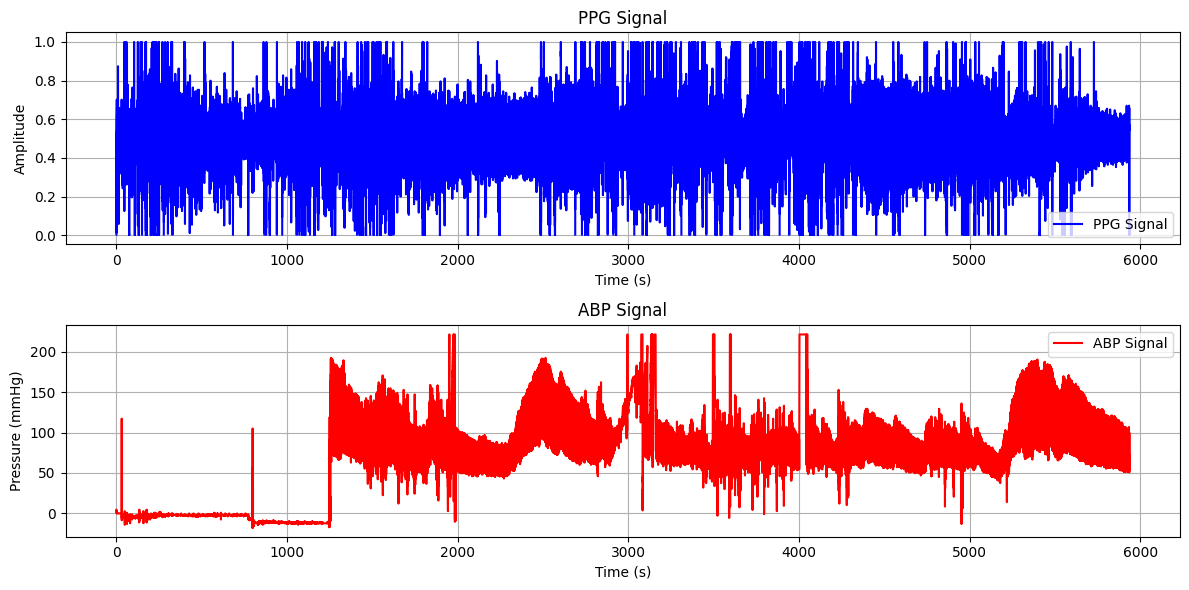

Signal after interpolation




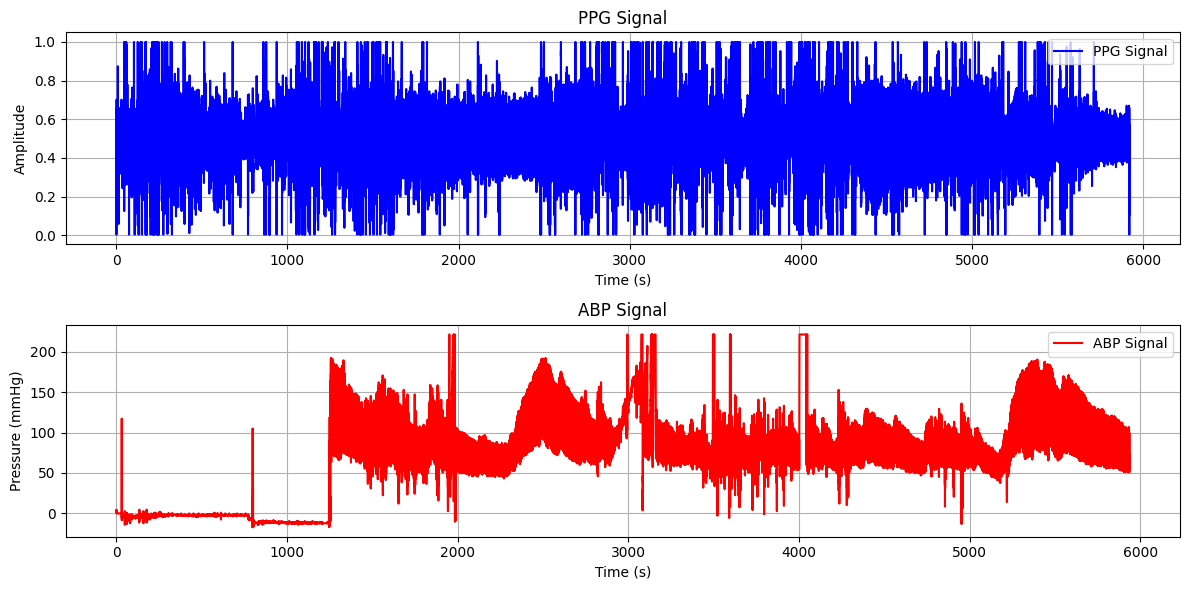

In [ ]:
#import libraries
import io
import os
import pandas as pd
import numpy as np
import wfdb
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
from scipy.stats import zscore

def interpolate_and_clean(signal, fs, cluster_threshold=0.5):
    """
    Handle NaN and infinite values in the signal using a hybrid strategy:
    - Interpolate sparse invalid values.
    - Remove clusters of invalid values exceeding a time threshold.

    Parameters:
    - signal: The signal array.
    - fs: Sampling frequency (in Hz).
    - cluster_threshold: Threshold for invalid clusters (in seconds).
    Returns:
    - Cleaned signal with no NaN or infinite values.
    """
    signal = np.array(signal)
    invalid_mask = np.isnan(signal) | np.isinf(signal)
    cluster_samples = int(cluster_threshold * fs)

    # Identify clusters of invalid values
    valid_signal = np.copy(signal)
    invalid_clusters = []
    start_idx = None

    for i, invalid in enumerate(invalid_mask):
        if invalid and start_idx is None:
            start_idx = i
        elif not invalid and start_idx is not None:
            if i - start_idx >= cluster_samples:
                invalid_clusters.append((start_idx, i))
            start_idx = None
    if start_idx is not None and len(signal) - start_idx >= cluster_samples:
        invalid_clusters.append((start_idx, len(signal)))

    # Interpolate sparse invalid values
    if invalid_mask.any():
        x = np.arange(len(signal))
        valid_signal[invalid_mask] = np.interp(
            x[invalid_mask], x[~invalid_mask], signal[~invalid_mask]
        )

    # Remove clusters of invalid data
    for start, end in invalid_clusters:
        valid_signal[start:end] = np.nan

    # Return a fully cleaned signal (removing any remaining NaN after interpolation)
    return valid_signal[~np.isnan(valid_signal)]

def plot_signals(ppg_segment, abp_segment, fs=125):
    """
    Plot PPG and ABP signals.
    - ppg_segment: Extracted PPG signal.
    - abp_segment: Extracted ABP signal.
    - fs: Sampling frequency (default: 125 Hz).
    """
    time_ppg = np.arange(0, len(ppg_segment)) / fs  # Create time axis in seconds

    time_abp = np.arange(0, len(abp_segment)) / fs

    # Plot PPG Signal
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time_ppg, ppg_segment, label="PPG Signal", color='blue')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("PPG Signal")
    plt.grid()
    plt.legend()

    # Plot ABP Signal
    plt.subplot(2, 1, 2)
    plt.plot(time_abp, abp_segment, label="ABP Signal", color='red')
    plt.xlabel("Time (s)")
    plt.ylabel("Pressure (mmHg)")
    plt.title("ABP Signal")
    plt.grid()
    plt.legend()

    # Show Plots
    plt.tight_layout()
    plt.show()

def process_signals_for_one_patient(patient_id, signals, fs=125, duration=2):
    """
    Process all signals for a single patient.
    Returns the first clean 5-minute aligned segment for both PPG and ABP signals if found.
    """
    for signal_path in signals:
            #analyzing model by extracting a single patient record
            signals, fields = wfdb.rdsamp('mimic3wdb/30/3000063/3000063_0006',
                              pn_dir='mimic3wdb/30/3000063',
                                     channel_names = ["PLETH", "ABP"])

            # Check for required signals and sampling frequency
            if fields["fs"] != fs or "PLETH" not in fields["sig_name"] or "ABP" not in fields["sig_name"]:
                continue

            ppg_idx = fields["sig_name"].index("PLETH")
            abp_idx = fields["sig_name"].index("ABP")

            ppg_signal = signals[:, ppg_idx]
            abp_signal = signals[:, abp_idx]

            print("Signal before interpolation\n\n")

            plot_signals(ppg_signal, abp_signal, fs=125)

            ppg_signal = interpolate_and_clean(ppg_signal, fs)
            abp_signal = interpolate_and_clean(abp_signal, fs)

            print("Signal after interpolation\n\n")

            plot_signals(ppg_signal, abp_signal, fs=125)


def main():
      patient_id = 3000003
      signals_data = [
            "30/3000063/3000063_0006"
        ]

      process_signals_for_one_patient(patient_id, signals_data)

if __name__ == "__main__":
    main()

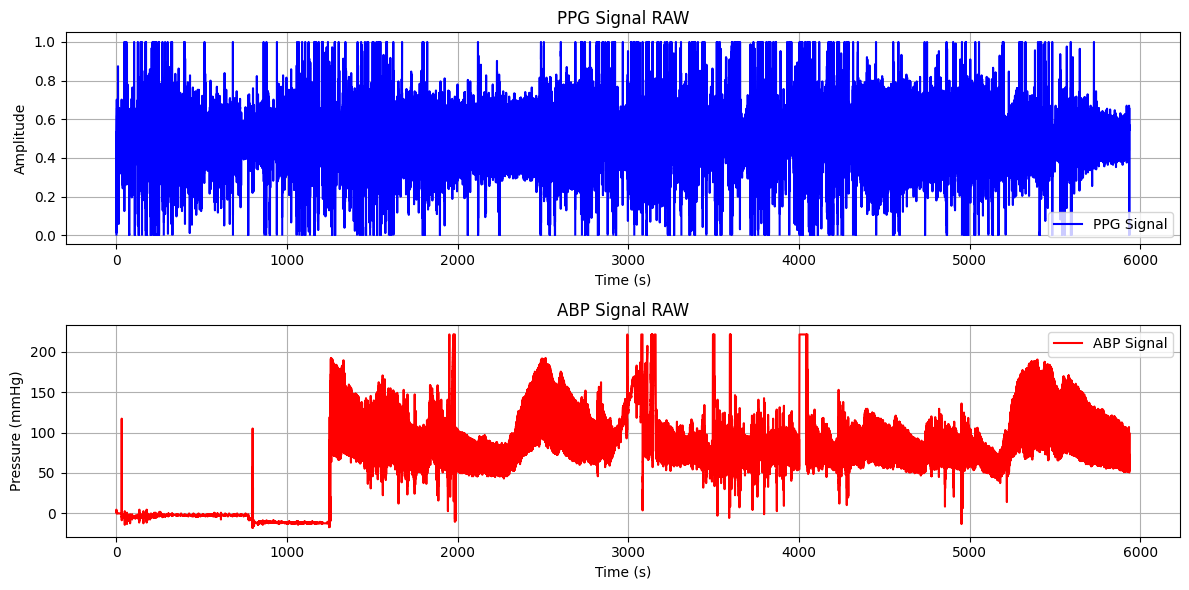

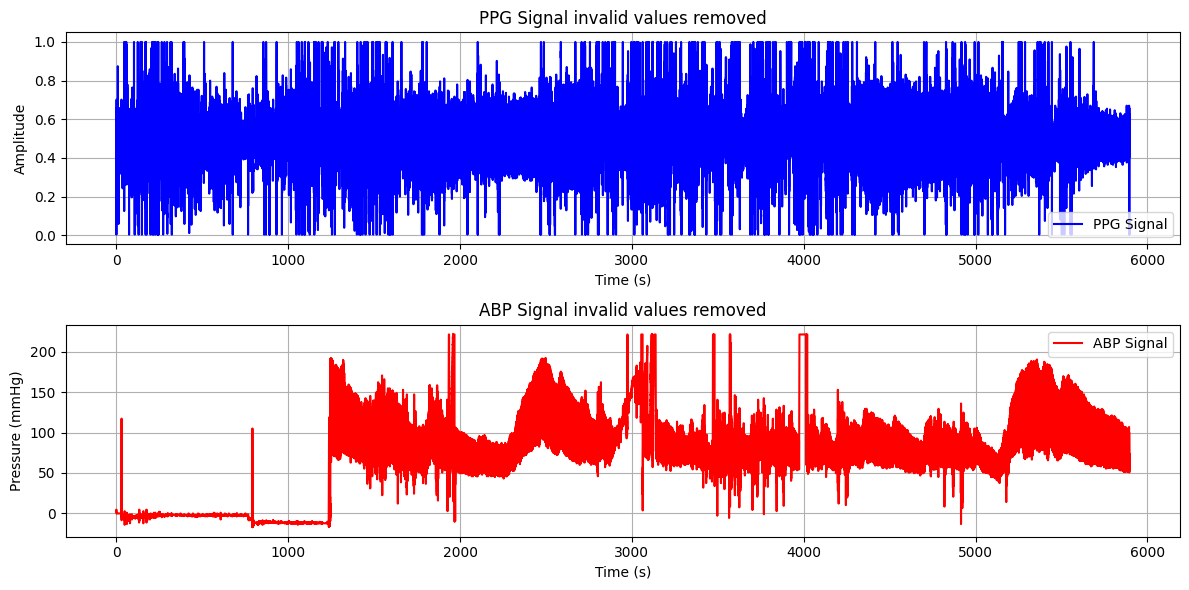

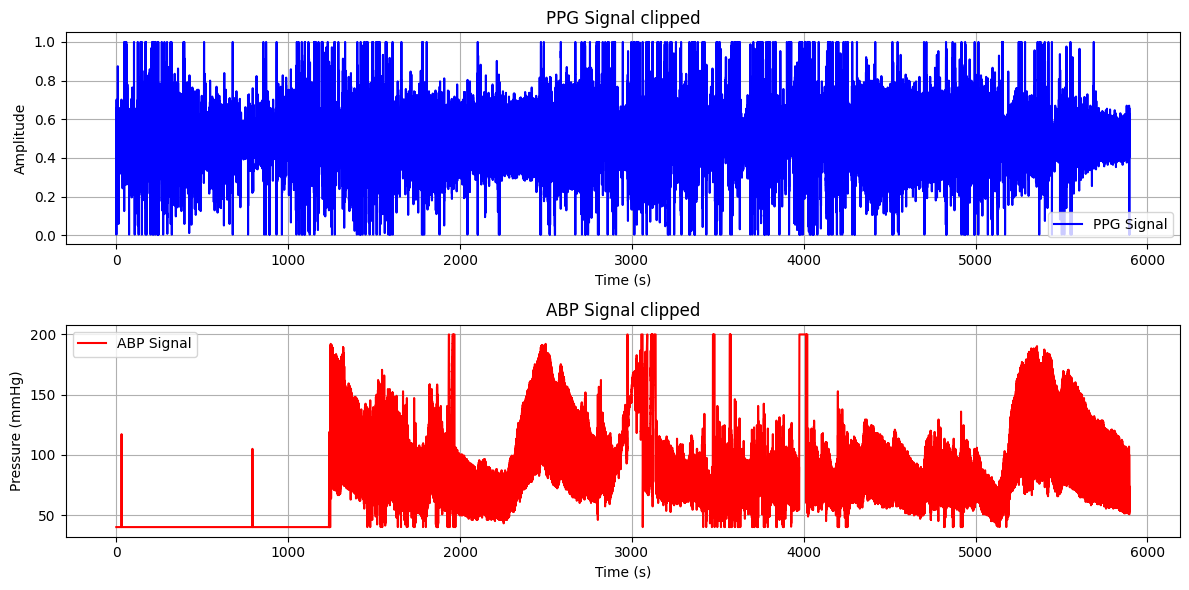

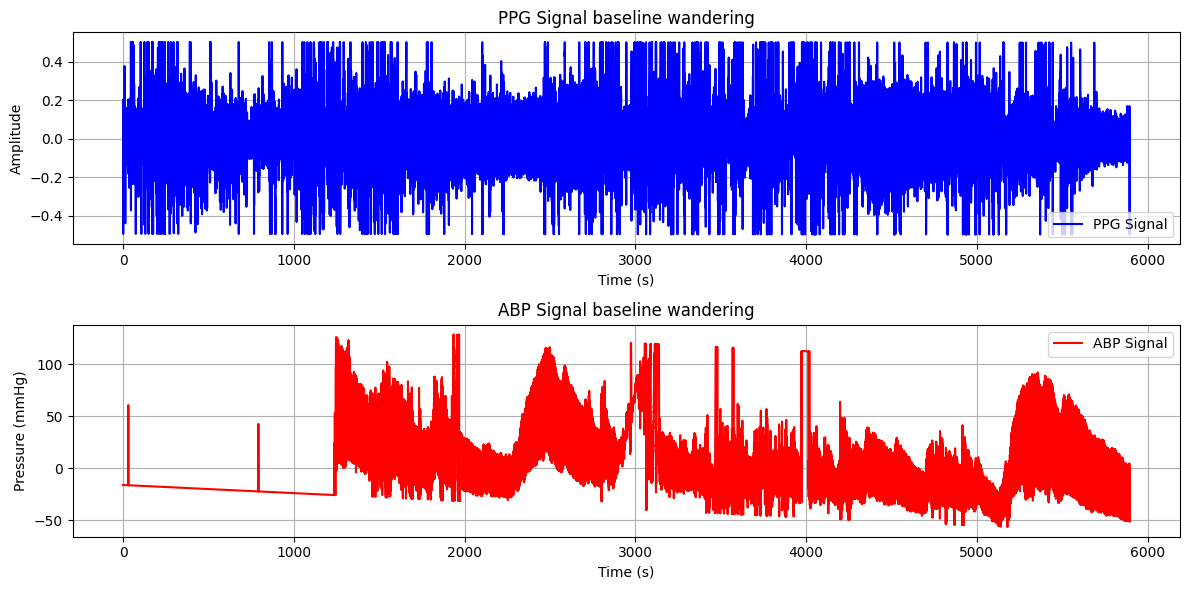

In [15]:
import io
import os
import pandas as pd
import numpy as np
import wfdb
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks, correlate
from scipy.signal import detrend

def plot_signals(ppg_segment, abp_segment, label, fs=125):
    """
    Plot PPG and ABP signals.
    - ppg_segment: Extracted PPG signal.
    - abp_segment: Extracted ABP signal.
    - fs: Sampling frequency (default: 125 Hz).
    """
    time_ppg = np.arange(0, len(ppg_segment)) / fs  # Create time axis in seconds

    time_abp = np.arange(0, len(abp_segment)) / fs

    # Plot PPG Signal

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time_ppg, ppg_segment, label="PPG Signal", color='blue')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"PPG Signal {label}")
    plt.grid()
    plt.legend()

    # Plot ABP Signal

    plt.subplot(2, 1, 2)
    plt.plot(time_abp, abp_segment, label="ABP Signal", color='red')
    plt.xlabel("Time (s)")
    plt.ylabel("Pressure (mmHg)")
    plt.title(f"ABP Signal {label}")
    plt.grid()
    plt.legend()

    # Show Plots
    plt.tight_layout()
    plt.show()

def remove_invalid_values(ppg_signal=None, abp_signal=None):
    """
    Remove NaN and infinite values from PPG and/or ABP signals, ensuring alignment if both are provided.

    Parameters:
    - ppg_signal: The PPG signal array (NumPy array), optional.
    - abp_signal: The ABP signal array (NumPy array), optional.

    Returns:
    - cleaned_ppg: Cleaned PPG signal with invalid values removed (or None if not provided).
    - cleaned_abp: Cleaned ABP signal with corresponding indices removed (or None if not provided).
    """
    if ppg_signal is None and abp_signal is None:
        raise ValueError("At least one of 'ppg_signal' or 'abp_signal' must be provided.")

    if ppg_signal is not None:
        ppg_signal = np.array(ppg_signal)  # Ensure it's a NumPy array
    if abp_signal is not None:
        abp_signal = np.array(abp_signal)  # Ensure it's a NumPy array

    if ppg_signal is not None and abp_signal is not None:
        # Create a combined mask for valid values in both signals
        valid_mask = (
            np.isfinite(ppg_signal) &  # PPG signal has no NaN or Inf
            np.isfinite(abp_signal)    # ABP signal has no NaN or Inf
        )
        # Apply the mask to both signals
        cleaned_ppg = ppg_signal[valid_mask]
        cleaned_abp = abp_signal[valid_mask]
        return cleaned_ppg, cleaned_abp

    if ppg_signal is not None:
        # Clean only PPG signal
        valid_mask = np.isfinite(ppg_signal)  # PPG signal has no NaN or Inf
        cleaned_ppg = ppg_signal[valid_mask]
        return cleaned_ppg, None

    if abp_signal is not None:
        # Clean only ABP signal
        valid_mask = np.isfinite(abp_signal)  # ABP signal has no NaN or Inf
        cleaned_abp = abp_signal[valid_mask]
        return None, cleaned_abp

def zscore_normalization(signal):
    """
    Normalize the signal to have zero mean and unit variance.

    Parameters:
    - signal: NumPy array representing the input signal.

    Returns:
    - Normalized signal.
    """
    mean = np.mean(signal)
    std = np.std(signal)
    if std == 0:
        raise ValueError("Standard deviation is zero, cannot perform z-score normalization.")
    return (signal - mean) / std


def rescale_signal(signal):
    """
    Rescale the signal based on its maximum absolute value.
    Useful for normalizing signals with large variations.

    Parameters:
    - signal: NumPy array representing the input signal.

    Returns:
    - Rescaled signal.
    """
    max_abs_value = np.max(np.abs(signal))
    if max_abs_value == 0:
        raise ValueError("Signal has zero maximum absolute value, cannot rescale.")
    return signal / max_abs_value

def clip_signal(signal, lower_bound, upper_bound):
    """
    Clip the signal to a specified range.

    Parameters:
    - signal: Input signal (list or NumPy array).
    - lower_bound: Lower bound for the signal values.
    - upper_bound: Upper bound for the signal values.

    Returns:
    - Clipped signal (NumPy array).
    """

    # Convert to NumPy array if not already
    signal = np.array(signal)

    # Clip the signal values
    clipped_signal = np.clip(signal, lower_bound, upper_bound)

    return clipped_signal

def baseline_wander_removal(signal, fs=None, method='linear'):
    """
    Remove baseline wander from the signal using detrending.

    Parameters:
    - signal: Input signal (list or NumPy array).
    - fs: Sampling frequency (optional, not used in detrending but for context).
    - method: Method for detrending ('linear' or 'constant').
              'linear' removes a linear trend, 'constant' removes the mean.

    Returns:
    - Processed signal with baseline wander removed.
    """
    # Detrend the signal to remove baseline wander
    detrended_signal = detrend(signal, type=method)
    return detrended_signal


def main():
      #analyzing model by extracting a single patient record
            signals, fields = wfdb.rdsamp('mimic3wdb/30/3000063/3000063_0006',
                              pn_dir='mimic3wdb/30/3000063',
                                     channel_names = ["PLETH", "ABP"])


            ppg_idx = fields["sig_name"].index("PLETH")
            abp_idx = fields["sig_name"].index("ABP")

            ppg_signal = signals[:, ppg_idx]
            abp_signal = signals[:, abp_idx]

            plot_signals(ppg_signal, abp_signal, "RAW", fs=125)

            ppg_signal, abp_signal = remove_invalid_values(ppg_signal, abp_signal)

            plot_signals(ppg_signal, abp_signal, "invalid values removed", fs=125)

            abp_signal = clip_signal(abp_signal, 40, 200)

            plot_signals(ppg_signal, abp_signal, "clipped", fs=125)

            ppg_signal = baseline_wander_removal(ppg_signal, fs=125, method='linear')
            abp_signal = baseline_wander_removal(abp_signal, fs=125, method='linear')

            plot_signals(ppg_signal, abp_signal, "baseline wandering", fs=125)



if __name__ == "__main__":
    main()

